Dataset can be found here: https://www.kaggle.com/shivamb/netflix-shows

Here we will do some basic analysis and visualization using a Kaggle dataset of Netflix shows and films. We'll clean up our data and get it ready for plotting, and we'll build a pie chart, two identical bar graphs with two different techniques, a stacked bar graph, and another bar graph with annotations and v-spans to highlight index ranges. Everything has markdowns and comments so I hope you get as much out of this notebook as I got out of learning to make it.  
  
If you have inputs or questions, there is an active community waiting for you on Discord that includes myself! https://discord.gg/2hcWnTF, and if you want to watch me make these in real-time and give your input or ask questions, I do this every Monday, Wednesday, and Friday on Twitch! https://twitch.tv/MitchsWorkshop  
  
Thanks for reading everyone!    

In [267]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set() # this seaborn function makes charts look prettier in the notebook, even if we aren't plotting with Seaborn
%matplotlib inline

In [268]:
# Reading our CSV file into a dataframe
flix = pd.read_csv("netflix_titles.csv")

The following cells are performing our cleaning tasks. Comments will provide contexts for individual lines. It's not the most fun aspect of working with data, but a huge chunk of working with data is preparing it for analysis, and it does become muscle memory before most other tasks you'll learn in your data journey. And it's just a few lines!

In [269]:
# Here, we use the df.drop() method to remove a list of columns (the 1 axis), the "inplace" parameter writes the change to the existing dataframe without the use of an assignment operator (=).
flix.drop(["cast", "director"], axis=1, inplace=True)

# The next two lines replace the "listed_in" and "country" columns. By default, they're a single string that look like a list. But we need them as an actual list, so we simply split the strings by their commas and we're done. 
flix["listed_in"] = flix["listed_in"].str.split(", ")
flix["country"] = flix["country"].str.split(", ")

# Removing rows where there are no "date_added" or "rating" values
flix = flix[flix["date_added"].isnull() == False]
flix = flix[flix["rating"].isnull()==False]

In [270]:
# This line converts the strings in the "date_added" column into Datetime objects, which is helpful in the next line.
flix["date_added"] = pd.to_datetime(flix["date_added"])

# Now that we have a datetime object, we can extract the year from those values and use those years to populate a new "year_added" column. 
flix["year_added"] = pd.DatetimeIndex(flix["date_added"]).year 

In [271]:
# This is where we split our dataframe into two different ones: one for films and one for TV shows. 
movies = flix[flix["type"] == "Movie"]
shows = flix[flix["type"] == "TV Show"]

Here we build a basic pie chart that shows the percent of content that is film or TV. We plot it using a colorblind-friendly palette, which is a nice consideration when plotting for the masses.

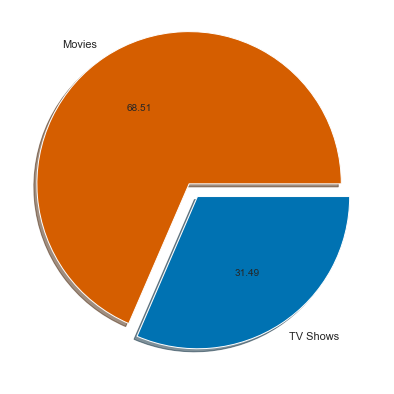

In [272]:
# Defining our colors and adding them to the list. We use the hex values here, but will use RGB later. 
cb_orange = "#d55e00"
cb_blue = "#0072b2"
colors = [cb_orange, cb_blue]

# Here we get our number of shows and movies by getting the length of both the shows and movies dataframes using the .shape attribute, which returns a tuple of (number_of_rows, number_of_columns).
num_shows = shows.shape[0]
num_movies = movies.shape[0]
total = num_movies + num_shows

# Using the number of shows/movies against the totals as a percent.
pct_shows = (num_shows/total)*100
pct_movies = (num_movies/total)*100

# Our pie chart demands a list of percentage values, which we will make more helpful by adding a labels list that will display on our final chart.
wedges = [pct_movies, pct_shows]
labels = ["Movies", "TV Shows"]

# Building our plot
plt.figure(figsize=(7,7))
ax = plt.pie(
    wedges, # our list of values, called "wedges" in a pie chart
    labels=labels, # labelling each wedge with our labels list
    shadow=True, # Shadow is purely cosmetic, but it looks nice.
    autopct=f"%.2f", # autopct displays the percent values on the wedges. %.2f shows a float value (f) to two decimal places (.2)
    explode=(.1,0), # This tuple moves the wedges away from center. Here we move the first one by .1, and dont' move the second
    colors=colors # changing colors of the wedges with our colors list
    )
plt.show() # display the plot

In the next cell, we produce a bar graph that displays the content added by year. We will display the same information in a different way later. Here, we use regular old plt.bar() and pass in a Series to the x and y parameters. A quick title finishes it out.

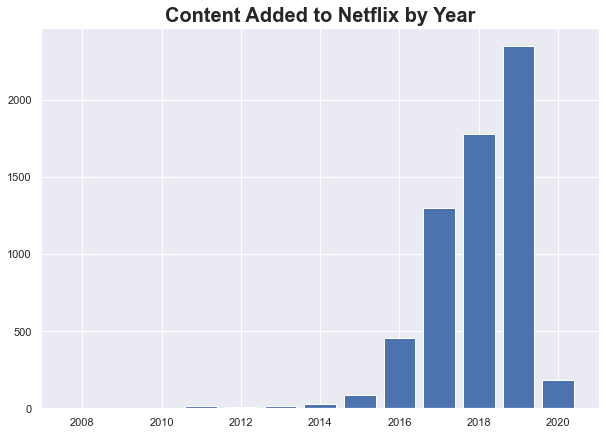

In [273]:
fig = plt.figure(figsize=(10,7))
plt.bar(
    flix["year_added"].value_counts().index, # .value_counts() returns a series, for which the .index attribute displays its indecies as an iterable, which gives us our x axis.
    flix["year_added"].value_counts() # .value_counts() is the values Series that corresponds with its own .index values
    )
plt.title("Content Added to Netflix by Year", fontsize=20, fontweight="bold")
plt.show()

Here, we plot the same data using a groupby object and its .size() method. The .size() method returns a Series object with indecies that are the unique values of the column that you grouped by ("year_added" in this case), and the count of those values as the elements in the series. The behavior is similar to the .value_counts() method used above. The difference here is that we use the Series.plot.bar() method to plot our chart, where we don't have to explicitly pass our x and y values.  
  
You'll notice slight differences in aesthetic which are caused by different default values used by the Series.plot.bar() method versus the plt.bar() function.

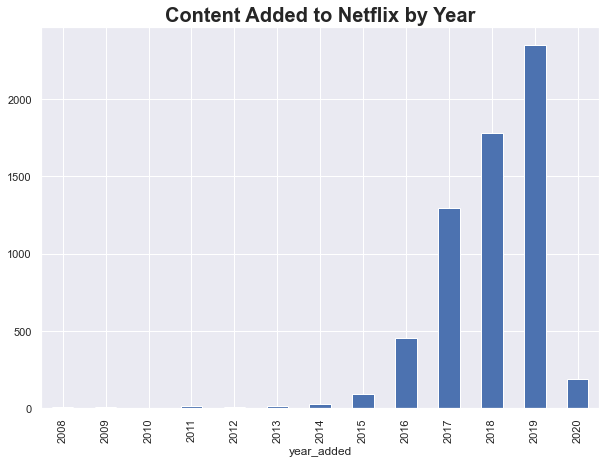

In [274]:
# Creating our groupby object and using it to get a Series object (ser) that we will use to plot
g = flix.groupby("year_added")
ser = g.size()

fig, ax = plt.subplots(figsize=(10,7))
ax = ser.plot.bar() # simply using the Series.plot.bar() method to plot
ax.set_title("Content Added to Netflix by Year", fontsize=20, fontweight="bold")
plt.show()

In the next cell, we take it up a notch. Instead of just viewing the total number of new pieces of content, we separate the bars into types of content (shows and movies), and stack them to compare the distribution of each type by year. This gives us more insight into the data without changing the footprint of the chart. We'll start by using the same "groupby" technique as the previous cell. The only difference this time is that we populate two different lists for each type of content.  
  
As you can see, when we create our groupby object, we group by a list of columns and not a single column. We then produce a Series using the same groupby.size() method. This causes a unique searching situation:  
  
To search a Series (a one-dimensional iterable), by index we need a tuple, where the first value is the first column we grouped by, and the second value is the second column. For example, if we want the number of new TV shows in 2018, we would search using ser\[(2018, "TV Show")\]. We use this technique to search by year, and populate our shows and movies data lists in order by year (via "for" loop).  
  
The two "try" statements check for conditions where there are no shows or movies in a given year, which will raise a KeyError. In the event that that happens, we know that the correct value for that year is 0, which we handle in our "except" statements.

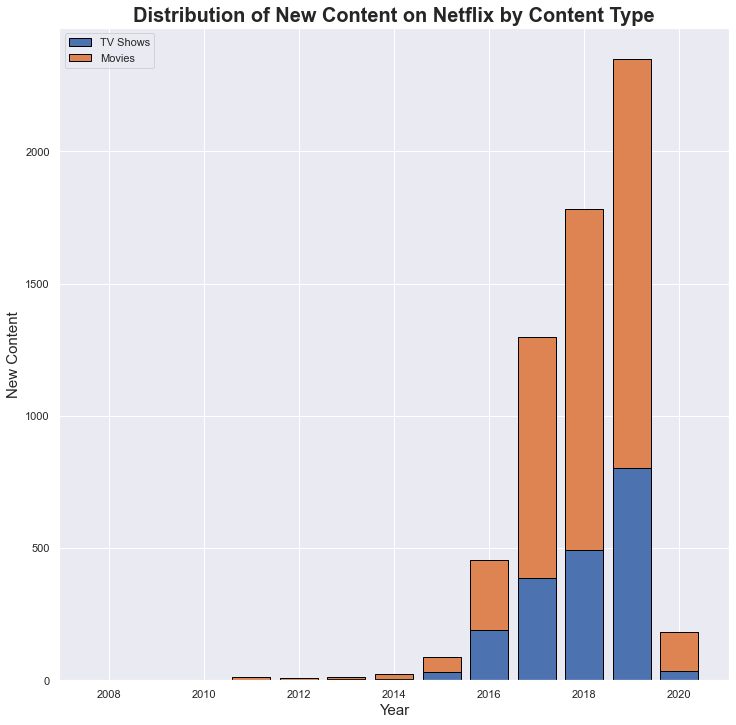

In [275]:
# Groupby object by two columns, and the .size() series
g = flix.groupby(["year_added", "type"])
ser = g.size()

# years column sorted in ascending order with the python sorted() function
years = sorted(flix["year_added"].unique())

# two lists that will become our y-values
shows_data = []
movies_data = []

# We iterate through every year, search for the number of shows and movies for that year, and append to the relevant list. See the paragraph above this cell for a brief explanation on the "try" statements. 
for year in years:
    try: 
        shows_data.append(ser[(year, "TV Show")])
    except:
        shows_data.append(0)
    try:
        movies_data.append(ser[(year, "Movie")])
    except:
        movies_data.append(0)


fig, ax = plt.subplots(figsize=(12, 12))

# the first bar graph will sit on the x-axis like a normal bar graph
ax.bar(
    years, # x data is the list of years
    shows_data, # this graph is displaying the TV Shows data
    label="TV Shows", # this label is used to produce the legend
    edgecolor="black" # outlining the bars in black
    )

# the bars of the second graph will sit atop the first ones, which produces a stacking effect
ax.bar(
    years, # same values for the x-axis data
    movies_data, # this graph is displaying the Movies data
    label="Movies", # again labelling for the legend
    bottom=shows_data, # The "bottom" parameter takes in an iterable to place the bottom of the bars in order. We simply pass it the shows_data values, which sets these bars atop the other.
    edgecolor="black" # outlining the bars
    )

ax.set_title("Distribution of New Content on Netflix by Content Type", fontsize=20, fontweight="bold")
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("New Content", fontsize=15)
ax.legend() # enabling a legend that is populated using each plots "label" parameter values
plt.show()

Finally, we go a little crazy. Here, we populate a bar graph that displays the number of pieces of content by rating. There will be color-coded annotations, denoting age ranges for the various ratings. We will be adhering to a color-blind friendly palette once again, with two using hex values and two using RGB values.  
  
Inside a "for" loop we will iterate through our labels and populate an annotation for each. We will use a "vspan" (short for "vertical span") to highlight ranges over the entire graph. After those annotations are built, we will plot our bars on top for ease of visibility.  
  
Full disclosure, I did not invent the logic or idea for this plot. I just added some touches and some comments. More great instruction from the Kaggle user that I shamelessly stole this from here: https://www.kaggle.com/subinium/simple-matplotlib-visualization-tips

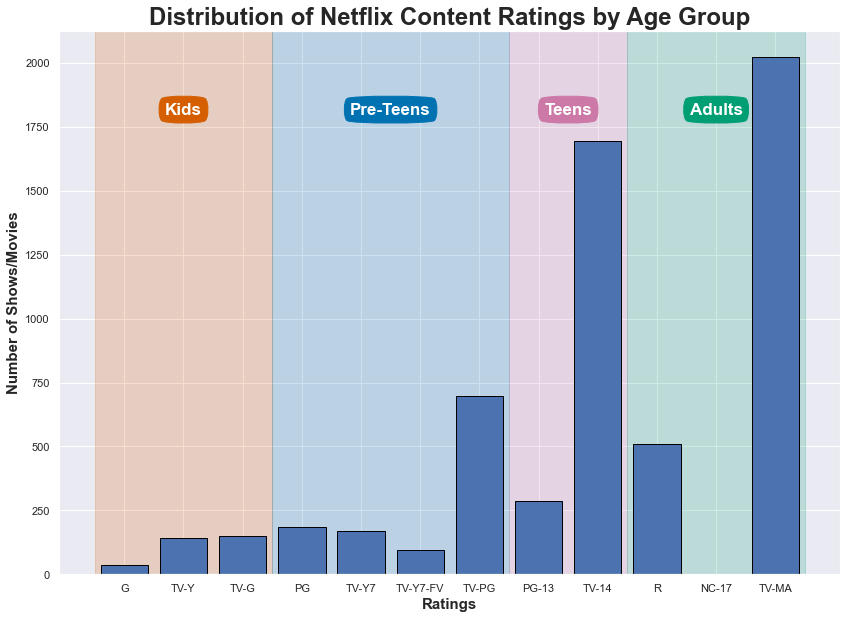

In [276]:
# Using hex and RGB to populate a colors list. 
cb_orange = "#d55e00"
cb_pink = "#cc79a7"
cb_blue = (0/255, 114/255, 178/255)
cb_green = (0/255, 158/255, 115/255)
colors = [cb_orange, cb_blue, cb_pink, cb_green]

# this is a list of every rating, ordered by age demographics. We will use it to order our .value_counts() series in the next line
ratings_list = ["G", "TV-Y", "TV-G", "PG", "TV-Y7", "TV-Y7-FV", "TV-PG", "PG-13", "TV-14", "R", "NC-17", "TV-MA"]

# using our manually-ordered ratings_list to reorder our series
ratings = flix["rating"].value_counts()[ratings_list]

# These tuples of age ranges and the corresponding labels will come into consideration later. age_groups is the first and last index of the ratings_list for each age_label
age_groups = [(0, 2), (3, 6), (7, 8), (9, 11)]
age_labels = ["Kids", "Pre-Teens", "Teens", "Adults"]

fig, ax = plt.subplots(figsize=(14,10))

# here we interate through our age_labels and use an index produced by enumerate() to assign colors and shape our vspans
for i, label in enumerate(age_labels):
    # display boxes with text annotating each vspan
    ax.annotate(
        label,
        xy=(sum(age_groups[i])/2, 1800), # this will center our annotations within the vspan, at height 1800
        ha="center", # By default, the bottom-left corner of the text is placed at the xy point above. This parameter makes it so the reference point is instead at the center of the text. Comment it out to see what happens.
        color="white",
        fontsize=17,
        fontweight="bold",
        bbox=dict(boxstyle="round4", color=colors[i], pad=.4) # this dict assigns parameters to a bbox, which is a box that will sit behind the text to help it stand out. Play with these parameters and see what happens!
    )

    # After the annotation is built, here we build the vspan that corresponds. We use our age_groups tuples and our colors list to assign width and color. Change all of these parameters or comment out this line to really dig in.
    ax.axvspan(age_groups[i][0]-0.5, age_groups[i][1]+0.5, alpha=0.2, color=colors[i])

# Finally, we display the plot!
ax.bar(ratings.index, ratings, edgecolor="black")
ax.set_title("Distribution of Netflix Content Ratings by Age Group", fontsize=24, fontweight="bold")
ax.set_xlabel("Ratings", fontsize=15, fontweight="bold")
ax.set_ylabel("Number of Shows/Movies", fontsize=15, fontweight="bold")
plt.show()

I hope you guys get something out of this notebook. I definitely did while I was building it! If you see anything that I did wrong or have any questions that I can help clarify, there's a Discord server waiting for you (https://discord.gg/2hcWnTF)! If you want to see my process, I make all of my notebooks live on my Twitch stream here: https://twitch.tv/MitchsWorkshop.  
  
Thank you so much for reading to the end. See you all in the next one!
- Mitch